Wie bestimme ich am besten die Range in der das ganze auslöst?

In [4]:
import ast
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

arg = "1011"
rounds = 99

file_name_arduino = f"data_arduino/arduino_data_{arg}.txt"
file_name_stage = f"data_stage/stage_data_{arg}.txt"

# Read the content of the file
with open(file_name_arduino, "r") as file:
    arduino_data = file.read()

with open(file_name_stage, "r") as file:
    stage_data = file.read()

stage_data = eval(stage_data.replace("datetime.datetime", "datetime").replace("datetime.timedelta", "timedelta"))
stage_data = stage_data[1:len(stage_data)]  

arduino_data = ast.literal_eval(arduino_data)
arduino_data = arduino_data[1:len(arduino_data)]            # shorten data because of errorous first round 
arduino_data = [[[int(v) for v in value] for value in sublist] for sublist in arduino_data]     # convert to int

In [18]:
switch_pos_fw_b0 = []
switch_pos_fw_b1 = []
switch_pos_fw_b2 = []
switch_pos_fw_f0 = []
switch_pos_fw_f1 = []

switch_pos_bw_b0 = []
switch_pos_bw_b1 = []
switch_pos_bw_b2 = []
switch_pos_bw_f0 = []
switch_pos_bw_f1 = []

 # [f0, f1, b0, b1, b2], [fw, bw, other]
for i in range(rounds-1):
    # alle fw rounds von b0
    pos_fw_uncorrected = [sublist[0] for sublist in stage_data[i]]
    pos_bw_uncorrected = [sublist[1] for sublist in stage_data[i]]
    
    pos_fw = []
    for x in pos_fw_uncorrected:
        if x is not None:  # Check if x is not None before subtracting
            pos_fw.append(x - 41.4)
        else:
            pos_fw.append(None)  # Or handle the case when x is None differently, if needed    
            
    pos_bw = []
    for x in pos_bw_uncorrected:
        if x is not None:  # Check if x is not None before subtracting
            pos_bw.append(x - 41.4)
        else:
            pos_bw.append(None)  # Or handle the case when x is None differently, if needed

    reed_f0 =  [sublist[0] for sublist in arduino_data[i]]
    reed_f1 =  [sublist[1] for sublist in arduino_data[i]]
    reed_b0 =  [sublist[2] for sublist in arduino_data[i]]
    reed_b1 =  [sublist[3] for sublist in arduino_data[i]]
    reed_b2 =  [sublist[4] for sublist in arduino_data[i]]
    
    for j in range(len(reed_b0)-1):
        if (reed_f0[j]==0) & (reed_f0[j+1]!=0):
            switch_pos_fw_f0.append((pos_fw[j]+pos_fw[j-1])/2)        
        if (reed_f1[j]==0) & (reed_f1[j+1]!=0):
            switch_pos_fw_f1.append((pos_fw[j]+pos_fw[j-1])/2)
        if (reed_b0[j]==0) & (reed_b0[j+1]!=0):
            switch_pos_fw_b0.append((pos_fw[j]+pos_fw[j-1])/2)       
        if (reed_b1[j]==0) & (reed_b1[j+1]!=0):
            switch_pos_fw_b1.append((pos_fw[j]+pos_fw[j-1])/2)        
        if (reed_b2[j]==0) & (reed_b2[j+1]!=0):
            switch_pos_fw_b2.append((pos_fw[j]+pos_fw[j-1])/2)          
            
        if (reed_f0[j]!=0) & (reed_f0[j+1]==0):
            switch_pos_bw_f0.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_f1[j]!=0) & (reed_f1[j+1]==0):
            switch_pos_bw_f1.append((pos_bw[j]+pos_bw[j-1])/2) 
        if (reed_b0[j]!=0) & (reed_b0[j+1]==0):
            switch_pos_bw_b0.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_b1[j]!=0) & (reed_b1[j+1]==0):
            switch_pos_bw_b1.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_b2[j]!=0) & (reed_b2[j+1]==0):
            switch_pos_bw_b2.append((pos_bw[j]+pos_bw[j-1])/2)  


Das ist der versuch einer parallelisierung, klappt aber nicht

In [6]:
import numpy as np

# Convert lists to numpy arrays for better performance
stage_data_np = np.array(stage_data)
arduino_data_np = np.array(arduino_data)

# Extract positions and reed switch data
pos_fw = stage_data_np[:, :, 0]
pos_bw = stage_data_np[:, :, 1]
reed_data = arduino_data_np[:, :, :5]

# Create arrays to store switch positions
switch_pos_fw = [[] for _ in range(5)]
switch_pos_bw = [[] for _ in range(5)]

# Find indices where reed switch state changes
fw_switch_indices = np.argwhere((reed_data[:, :-1, :] == 0) & (reed_data[:, 1:, :] != 0))
bw_switch_indices = np.argwhere((reed_data[:, :-1, :] != 0) & (reed_data[:, 1:, :] == 0))

# Extract switch positions
for i, (j, k) in enumerate(fw_switch_indices):
    switch_pos_fw[k].append((pos_fw[i, j] + pos_fw[i, j - 1]) / 2)

for i, (j, k) in enumerate(bw_switch_indices):
    switch_pos_bw[k].append((pos_bw[i, j] + pos_bw[i, j - 1]) / 2)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (99,) + inhomogeneous part.

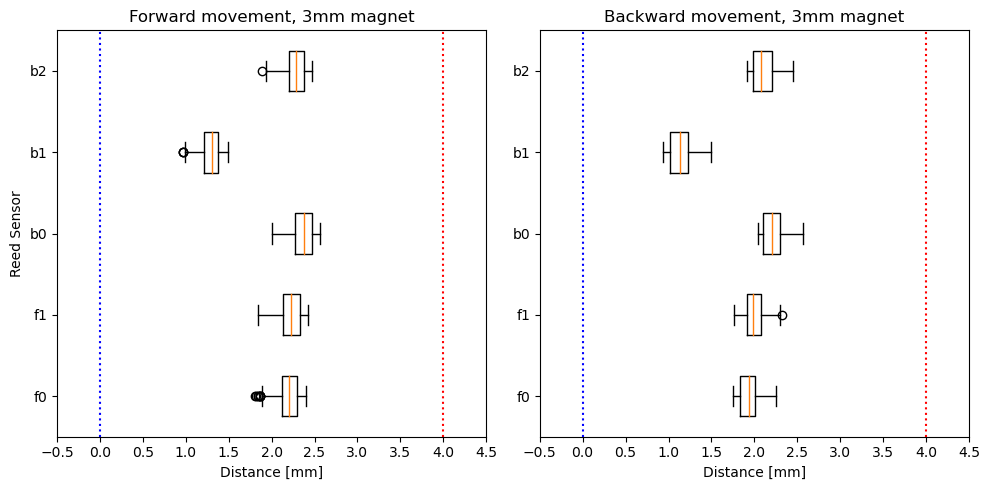

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x_fw = [switch_pos_fw_f0, switch_pos_fw_f1, switch_pos_fw_b0, switch_pos_fw_b1, switch_pos_fw_b2]
x_bw = [switch_pos_bw_f0, switch_pos_bw_f1, switch_pos_bw_b0, switch_pos_bw_b1, switch_pos_bw_b2]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the first boxplot on the first subplot
axes[0].boxplot(x_fw, vert=False)
axes[1].boxplot(x_bw, vert=False)

axes[0].set_xlabel('Distance [mm]')
axes[0].set_ylabel('Reed Sensor')
axes[0].set_title('Forward movement, 3mm magnet')
axes[1].set_title('Backward movement, 3mm magnet')

for axis in axes.flat:
    axis.set_xlabel('Distance [mm]')
    axis.set_yticks([1,2,3,4,5],['f0', 'f1', 'b0', 'b1', 'b2'])
    axis.set_xticks([-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5])
    axis.axvline(x=0, color = 'b', ls=':')
    axis.axvline(x=4, color = 'r', ls=':')


plt.tight_layout()
plt.show()


Print all Reed Back

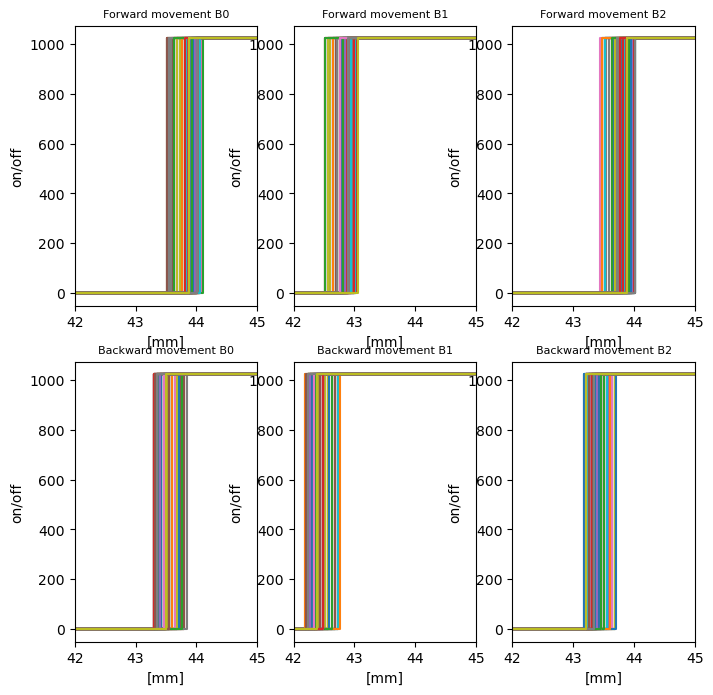

In [2]:
import matplotlib 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

fig, ax = plt.subplots(2,3, figsize=(8,8))

matplotlib.rc('axes', labelsize=SMALL_SIZE) 
matplotlib.rc('ytick', labelsize=SMALL_SIZE)
matplotlib.rc('ytick', labelsize=SMALL_SIZE)

 # [f0, f1, b0, b1, b2], [fw, bw, other]
for i in range(rounds-1):
    # alle fw rounds von b0
    ax[0,0].step([sublist[0] for sublist in stage_data[i]], [sublist[2] for sublist in arduino_data[i]])
    # alle bw rounds von b0 
    ax[1,0].step([sublist[1] for sublist in stage_data[i]], [sublist[2] for sublist in arduino_data[i]]) 
     # alle fw rounds von b1
    ax[0,1].step([sublist[0] for sublist in stage_data[i]], [sublist[3] for sublist in arduino_data[i]])
    # alle bw rounds von b1
    ax[1,1].step([sublist[1] for sublist in stage_data[i]], [sublist[3] for sublist in arduino_data[i]])     # alle fw rounds von b1
    # alle fw rounds von b2   
    ax[0,2].step([sublist[0] for sublist in stage_data[i]], [sublist[4] for sublist in arduino_data[i]])
    # alle bw rounds von b2
    ax[1,2].step([sublist[1] for sublist in stage_data[i]], [sublist[4] for sublist in arduino_data[i]])


ax[0,0].set_title('Forward movement B0', size=SMALL_SIZE)
ax[1,0].set_title('Backward movement B0', size=SMALL_SIZE)
ax[0,1].set_title('Forward movement B1', size=SMALL_SIZE)
ax[1,1].set_title('Backward movement B1', size=SMALL_SIZE)
ax[0,2].set_title('Forward movement B2', size=SMALL_SIZE)
ax[1,2].set_title('Backward movement B2', size=SMALL_SIZE)

for axis in ax.flat:
    axis.set(xlabel='[mm]', ylabel='on/off')
    #axis.set_xticks([35,37,39,41,43,45])
    axis.set_xlim([42,45])

plt.show() 

Print all Reed Front 

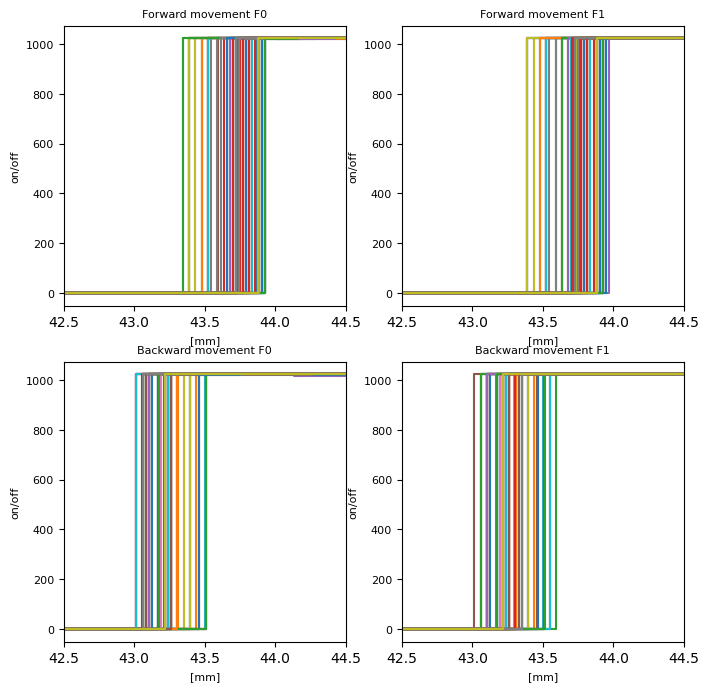